# <font color='red'>IMPORTANT
This jupyter notebook served as a development platform and was used in google colab and later locally. The results for the Occupancy Detection part in the Evaluation part of the thesis are taken from this notebook.</font>

## Import libraries

In [1]:
import wandb
from wandb.keras import WandbCallback

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import apply_affine_transform
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
import mmap
import math
import random
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter

In [2]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


# Helper functions

In [4]:
def count_file_lines(dataset_path:str) -> int:
  file_path = dataset_path if '.txt' in dataset_path else os.path.join(OCD_DATA_DIR, 'splits', dataset_path, 'all.txt')
  fp = open(file_path, 'r+')
  buf = mmap.mmap(fp.fileno(), 0)
  lines = 0
  while buf.readline():
    lines += 1

  return lines

In [5]:
def check_all_files_exist(dataset_path:str) -> list:
  invalid_paths = list()
  with open(os.path.join(OCD_DATA_DIR, 'splits', dataset_path, 'all.txt')) as f:
    for line in tqdm(f, total=count_file_lines(dataset_path)):
      image_path = os.path.join(OCD_DATA_DIR, dataset_path, line.split()[0])
      if not os.path.exists(image_path):
        invalid_paths.append(image_path)
        print(image_path)

  return invalid_paths

In [3]:
def init(verify_files_exist:bool=False) -> None:
  # initialize directory paths
  global OCD_DATA_DIR, CNRParkAB_PATH, CNRParkEXT_PATH, PKLot_PATH, SvJur_PATH
  DIR_PREFIX = 'C:\\Users\\krock\\My Drive\\DP'
  OCD_DATA_DIR = os.path.join(DIR_PREFIX, 'Datasets\\OccupancyDetection')
  CNRParkAB_PATH = 'CNRParkAB'
  CNRParkEXT_PATH = 'CNRPark-EXT'
  PKLot_PATH = 'PKLot\\PKLotSegmented'
  SvJur_PATH = 'SvJur'
  MODEL_PATH = os.path.join(DIR_PREFIX, 'Models\\keras_mAlexNet\\out_keras.h5')

  # verify files exist
  if verify_files_exist:
    for d_path in [CNRParkAB_PATH, CNRParkEXT_PATH, PKLot_PATH, SvJur_PATH]:
      missing_files = check_all_files_exist(d_path)
      if missing_files: print(d_path, 'files missing:', missing_files)

  # load keras model
  global loaded_model, target_img_size
  loaded_model = keras.models.load_model(MODEL_PATH)
  target_img_size = loaded_model.inputs[0].shape[1:-1]

  global labels_mapping
  labels_mapping = {0: 'free', 1: 'occupied'}

In [ ]:
init()

# Data

In [11]:
def preprocess_image(filename:str, img_size:int=224, expand_dims:bool=True) -> np.array:
    image = cv2.imread(filename, cv2.IMREAD_UNCHANGED) * 1. / 255
    image = cv2.resize(image, (img_size, img_size))
    image = np.expand_dims(image, axis=0) if expand_dims else image
    return image

In [8]:
def right_angle_rotate(input_image):
    angle = random.choice([0, 90, 180, 270])
    if angle != 0:
        input_image = apply_affine_transform(input_image, theta=angle)
    return input_image

In [9]:
def image_generator(input_path:str, bs:int, subdir_path:str='', mode:str='train', img_size:int=224):
	file_path = input_path if '.txt' in input_path else os.path.join(OCD_DATA_DIR, 'splits', input_path, subdir_path, 'all.txt')
	f = open(file_path, 'r')

	while True:
		images = []
		labels = []

		while len(images) < bs:
			line = f.readline()
			if line == '':
				f.seek(0)
				line = f.readline()
				if mode == 'eval':
					break

			image_path, label = line.strip().split(' ')
			image_path = os.path.join(OCD_DATA_DIR, image_path) if '.txt' in input_path else os.path.join(OCD_DATA_DIR, input_path, image_path)

			image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED) * 1. / 255
			image = cv2.resize(image, (img_size, img_size))

			images.append(image)
			labels.append(label)


		# rotate randomly by 90, 180, 270 degrees
		if mode == 'train':
			images = [right_angle_rotate(image) for image in images]

		# randomly shuffle
		temp = list(zip(images, labels))
		random.shuffle(temp)
		images, labels = zip(*temp)	# tuples
		images, labels = list(images), list(labels)	# convert to lists

		yield (np.array(images), np.array(labels).astype('uint8'))

In [10]:
def count_labels_occurence(dataset_path:str='', labels_list:list=None):
    if dataset_path != '':
        file_path = dataset_path if '.txt' in dataset_path else os.path.join(OCD_DATA_DIR, 'splits', dataset_path, 'all.txt')
        with open(file_path, 'r') as f:
            return Counter([line.strip().split(' ')[1] for line in f.readlines()])
    elif labels_list:
        return Counter([line.strip().split(' ')[1] for line in labels_list])

In [ ]:
print('CNRParkAB labels', count_labels_occurence(CNRParkAB_PATH))
print('CNRParkEXT labels',  count_labels_occurence(CNRParkEXT_PATH))
print('PKLot labels',  count_labels_occurence(PKLot_PATH))
print('SvJur labels',  count_labels_occurence(SvJur_PATH))
print('Ultimate train', count_labels_occurence(os.path.join(OCD_DATA_DIR, 'splits', 'random', 'train.txt')))
print('Ultimate validation', count_labels_occurence(os.path.join(OCD_DATA_DIR, 'splits', 'random', 'validation.txt')))
print('Ultimate test', count_labels_occurence(os.path.join(OCD_DATA_DIR, 'splits', 'random', 'test.txt')))

In [41]:
def create_ultimate_txt_file(d_paths:list, val_split_ratio:float=0.8):
    train_lines_final, validation_lines_final, test_dataset = [], [], []

    for d_path in d_paths:
        filepath = os.path.join(OCD_DATA_DIR, 'splits', d_path, 'all.txt')

        with open(filepath, 'r') as f:
            lines = [os.path.join(d_path, line) for line in f.readlines()]

        labels_0 = [line for line in lines if line.strip().endswith('0')]
        labels_1 = [line for line in lines if line.strip().endswith('1')]

        # heavily inbalanced dataset
        if 'SvJur' in filepath:
            random.shuffle(labels_0)
            labels_0 = labels_0[:len(labels_1)]
            assert len(labels_0) == len(labels_1)

        # reduce sample size from PKLot
        if 'PKLot' in filepath:
            random.shuffle(labels_0)
            random.shuffle(labels_1)
            labels_0 = labels_0[:int(len(labels_0) / 2)]
            labels_1 = labels_1[:int(len(labels_1) / 2)]

        # split using validation ratio
        limit_label_0 = int(len(labels_0) * val_split_ratio)
        limit_label_1 = int(len(labels_1) * val_split_ratio)

        # equal distribution - half of label 0 + half of label 1
        train_lines = labels_0[:limit_label_0] + labels_1[:limit_label_1]
        validation_lines = labels_0[limit_label_0:] + labels_1[limit_label_1:]

        if 'SvJur' not in filepath and 'PKLot' not in filepath:
            assert len(train_lines + validation_lines) == count_file_lines(filepath)
        train_lines_final += train_lines
        validation_lines_final += validation_lines

    # assert lists are mutually exclusive
    assert len(set(train_lines_final + validation_lines_final)) == len(train_lines_final + validation_lines_final)

    # equalize presence of 0 / 1 labels
    for dataset, dataset_name in zip([train_lines_final, validation_lines_final], ['train', 'validation']):
        random.shuffle(dataset)
        labels_0 = [line for line in dataset if line.strip().endswith('0')]
        labels_1 = [line for line in dataset if line.strip().endswith('1')]

        if len(labels_0) > len(labels_1):
            dataset = labels_0[:len(labels_1)] + labels_1
        else:
            dataset = labels_1[:len(labels_0)] + labels_0

        # assert equal distribution of 0 / 1 labels
        label_counts = count_labels_occurence(labels_list=dataset)
        assert label_counts['0'] == label_counts['1']

        if dataset_name == 'train':
            test_dataset += list(set(train_lines_final) - set(dataset))
        else:
            test_dataset += list(set(validation_lines_final) - set(dataset))

        # final shuffle and write to file
        random.shuffle(dataset)
        new_filepath = os.path.join(OCD_DATA_DIR, 'splits', 'random', f'{dataset_name}.txt')
        open(new_filepath, 'w').writelines(dataset)

    # create test dataset
    random.shuffle(test_dataset)
    new_filepath = os.path.join(OCD_DATA_DIR, 'splits', 'random', 'test.txt')
    open(new_filepath, 'w').writelines(test_dataset)

# create_ultimate_txt_file([CNRParkAB_PATH, CNRParkEXT_PATH, PKLot_PATH, SvJur_PATH])
# create_ultimate_txt_file([CNRParkAB_PATH, PKLot_PATH, SvJur_PATH])

In [ ]:
def create_merged_all_txt_file(dataset_1_path:str, dataset_2_path:str, ratio:int=1):
    'First dataset has to be smaller than second dataset'
    filepath_1 = os.path.join(OCD_DATA_DIR, 'splits', dataset_1_path, 'all.txt')
    filepath_2 = os.path.join(OCD_DATA_DIR, 'splits', dataset_2_path, 'all.txt')
    numlines_1 = count_file_lines(os.path.join(OCD_DATA_DIR, 'splits', dataset_1_path))

    with open(filepath_1, 'r') as f1, open(filepath_2, 'r') as f2:
        lines_1 = [os.path.join(dataset_1_path, line) for line in f1.readlines()]
        lines_2 = [os.path.join(dataset_2_path, line) for line in f2.readlines()]

        # balance 1st dataset label counts
        counts_1 = count_labels_occurence(dataset_path=dataset_1_path)
        lines_2_label_0 = [line for line in lines_2 if line.strip().endswith('0')]
        lines_2_label_1 = [line for line in lines_2 if line.strip().endswith('1')]
        lines_2_to_balance = lines_2_label_0[:counts_1['1']] + lines_2_label_1[:counts_1['0']]
        
        # check if counts match
        counts_check = count_labels_occurence(labels_list=lines_1 + lines_2_to_balance)
        assert counts_check['0'] == counts_check['1']

        # merge initial dataset 1 with complementary part of dataset 2
        balanced_lines = lines_1 + lines_2_to_balance

        # fill up to ratio with 2nd dataset (balanced)
        upper_limit = int(numlines_1 * (ratio - 1) / 2)
        balanced_lines_2 = lines_2_label_0[counts_1['1']:upper_limit + counts_1['1']] + lines_2_label_1[counts_1['0']:upper_limit + counts_1['0']]
        final_lines = balanced_lines + balanced_lines_2

        # check if counts match
        final_counts_check = count_labels_occurence(labels_list=final_lines)
        assert final_counts_check['0'] == final_counts_check['1']

        random.shuffle(final_lines)

        ratio_string = '1_to_' + str(ratio)
        new_filepath = os.path.join(OCD_DATA_DIR, 'splits', 'random', dataset_1_path + '_' + dataset_2_path.split('\\')[0] + '_' + ratio_string + '.txt')
        open(new_filepath, 'w').writelines(final_lines)

# create_merged_all_txt_file(SvJur_PATH, PKLot_PATH, ratio=4)

# RUN

In [17]:
train_dataset = os.path.join(OCD_DATA_DIR, 'splits', 'random', 'train_d.txt')
validation_dataset = os.path.join(OCD_DATA_DIR, 'splits', 'random', 'validation_d.txt')

# constants
STEPS_PER_EPOCH = 20
EPOCHS = 72
NUM_TRAIN_IMAGES = count_file_lines(train_dataset)
NUM_VALIDATION_IMAGES = count_file_lines(validation_dataset)

# wandb config
run = wandb.init(project='DP', entity='michaelkrocka',
            config={
               'epochs': EPOCHS,
               'batch_size_train': NUM_TRAIN_IMAGES / (EPOCHS * STEPS_PER_EPOCH),
               'batch_size_validation': NUM_VALIDATION_IMAGES / (EPOCHS / 4 * STEPS_PER_EPOCH), # / 4 because validation is 1/4 size of training
               'learning_rate': 1e-5,
               'loss_function': 'binary_crossentropy',
               'optimizer': 'Adam',
               'train_dataset': train_dataset,
               'validation_dataset': validation_dataset
            })
config = wandb.config

# generators
train_generator = image_generator(config.train_dataset, config.batch_size_train)
val_generator = image_generator(config.validation_dataset, config.batch_size_validation, mode='eval')

# model reconstruction
loaded_model = keras.models.load_model('C:\\Users\\krock\\My Drive\\DP\\Models\\keras_mAlexNet\\out_keras.h5')
model = keras.models.Sequential()
for layer in loaded_model.layers[:-2]:
   model.add(layer)
model.add(keras.layers.Dense(1, 'sigmoid'))

# optimizer
step = tf.Variable(0, trainable=False)
breakpoint = NUM_TRAIN_IMAGES / 3
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([breakpoint, breakpoint], [config.learning_rate, config.learning_rate / 2, config.learning_rate / 4])
lr = schedule(step)
opt = keras.optimizers.Adam(learning_rate=lr)

model.compile(loss=config.loss_function, optimizer=opt, metrics=['accuracy'])

# callbacks
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
cb_list = [es, mc, WandbCallback()]

# training
history = model.fit(
	x = train_generator,
	validation_data = val_generator,
   validation_steps = STEPS_PER_EPOCH,
	steps_per_epoch = STEPS_PER_EPOCH,
	epochs = config.epochs,
	callbacks = cb_list)

print(CNRParkAB_PATH, test_accuracy_on_dataset(model, CNRParkAB_PATH))
print(CNRParkEXT_PATH, test_accuracy_on_dataset(model, CNRParkEXT_PATH))
print(SvJur_PATH, test_accuracy_on_dataset(model, SvJur_PATH))
print(PKLot_PATH, test_accuracy_on_dataset(model, PKLot_PATH))

run.finish()

Epochs 72
StepsPerEpoch 20
NumTrainImages 407262
NumValidationImages 101818
BatchSizeTrain 1131.2833333333333
BatchSizeVal 565.6555555555556


Epoch 1/72
20/20 [==============================] - ETA: 0s - loss: 1.6059 - accuracy: 0.5049 
Epoch 1: val_accuracy improved from -inf to 0.49991, saving model to best_model.h5
20/20 [==============================] - 312s 16s/step - loss: 1.6059 - accuracy: 0.5049 - val_loss: 1.1666 - val_accuracy: 0.4999 - _timestamp: 1651997552.0000 - _runtime: 345.0000
Epoch 2/72
20/20 [==============================] - ETA: 0s - loss: 1.0230 - accuracy: 0.4956 
Epoch 2: val_accuracy improved from 0.49991 to 0.51095, saving model to best_model.h5
20/20 [==============================] - 258s 14s/step - loss: 1.0230 - accuracy: 0.4956 - val_loss: 0.6646 - val_accuracy: 0.5110 - _timestamp: 1651997810.0000 - _runtime: 603.0000
Epoch 3/72
20/20 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.6188 
Epoch 3: val_accuracy improved from 0.51095 to 0.81802, saving model to best_model.h5
20/20 [==============================] - 253s 13s/step - loss: 0.6149 - accuracy: 0.6188 - val_l

  0%|          | 0/12 [00:00<?, ?it/s]

all_model_5 CNRParkAB {'correct': 11544, 'incorrect': 1040}


  0%|          | 0/144 [00:00<?, ?it/s]

all_model_5 CNRPark-EXT {'correct': 132880, 'incorrect': 11970}


  0%|          | 0/33 [00:00<?, ?it/s]

all_model_5 SvJur {'correct': 33515, 'incorrect': 141}


  0%|          | 0/695 [00:00<?, ?it/s]

all_model_5 PKLot\PKLotSegmented {'correct': 669736, 'incorrect': 26115}


accuracy,▁▁▃▆▇▇▇▇▇▇▇▇▇█▇█████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▆█████████████████████████████████████
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.91246
best_epoch,41
best_val_loss,0.14643
epoch,46
loss,0.21583
val_accuracy,0.94832


# Accuracy testing

In [12]:
def test_accuracy_on_dataset(model, dataset_path:str, batch_size:int=1000) -> dict:
    file_path = dataset_path if '.txt' in dataset_path else os.path.join(OCD_DATA_DIR, 'splits', dataset_path, 'all.txt')
    pred_labels_dict = {'correct': 0, 'incorrect': 0}
    images, labels = [], []

    with open(file_path) as f:
        for line in tqdm(f, total=math.floor(count_file_lines(file_path) / batch_size)):

            while len(images) < batch_size:
                if line == '':
                    # predict the final incomplete batch
                    predictions = model.predict_on_batch(np.array(images))
                    if model.output_shape == (None, 2):
                        correct = sum(str(np.argmax(pred)) == label for pred, label in zip(predictions, labels))
                    else:
                        correct = sum(str(round(pred[0])) == label for pred, label in zip(predictions, labels))
                    pred_labels_dict['correct'] += correct
                    pred_labels_dict['incorrect'] += len(labels) - correct

                    # close file and return dict
                    f.close()
                    return pred_labels_dict
                
                # preprocess image
                orig_filename, label = line.strip().split(' ')
                filename = os.path.join(OCD_DATA_DIR, orig_filename) if '.txt' in dataset_path else os.path.join(OCD_DATA_DIR, dataset_path, orig_filename)
                image = preprocess_image(filename, expand_dims=False)
                
                images.append(image)
                labels.append(label)
                if len(images) < batch_size:
                    line = f.readline()

            # store number of correct / incorrect predictions
            predictions = model.predict_on_batch(np.array(images))
            if model.output_shape == (None, 2):
                correct = sum(str(np.argmax(pred)) == label for pred, label in zip(predictions, labels))
            else:
                correct = sum(str(round(pred[0])) == label for pred, label in zip(predictions, labels))
            pred_labels_dict['correct'] += correct
            pred_labels_dict['incorrect'] += batch_size - correct
            images, labels = [], []

In [22]:
for root, dirs, files in os.walk('C:\\Users\\krock\\Desktop\\FIIT\\Ing\\DP\\DP\\models'):
    for file in files:
        model = keras.models.load_model(os.path.join(root, file))
        print(file, CNRParkAB_PATH, test_accuracy_on_dataset(model, CNRParkAB_PATH))
        print(file, CNRParkEXT_PATH, test_accuracy_on_dataset(model, CNRParkEXT_PATH))
        print(file, SvJur_PATH, test_accuracy_on_dataset(model, SvJur_PATH))
        print(file, PKLot_PATH, test_accuracy_on_dataset(model, PKLot_PATH))

  0%|          | 0/12 [00:00<?, ?it/s]

angry-alpaca-186.h5 CNRParkAB {'correct': 11117, 'incorrect': 1467}


  0%|          | 0/144 [00:00<?, ?it/s]

angry-alpaca-186.h5 CNRPark-EXT {'correct': 129989, 'incorrect': 14861}


  0%|          | 0/33 [00:00<?, ?it/s]

angry-alpaca-186.h5 SvJur {'correct': 33375, 'incorrect': 281}


  0%|          | 0/695 [00:00<?, ?it/s]

angry-alpaca-186.h5 PKLot\PKLotSegmented {'correct': 680037, 'incorrect': 15814}


  0%|          | 0/12 [00:00<?, ?it/s]

atomic-totem-201.h5 CNRParkAB {'correct': 11250, 'incorrect': 1334}


  0%|          | 0/144 [00:00<?, ?it/s]

atomic-totem-201.h5 CNRPark-EXT {'correct': 128806, 'incorrect': 16044}


  0%|          | 0/33 [00:00<?, ?it/s]

atomic-totem-201.h5 SvJur {'correct': 33518, 'incorrect': 138}


  0%|          | 0/695 [00:00<?, ?it/s]

atomic-totem-201.h5 PKLot\PKLotSegmented {'correct': 669979, 'incorrect': 25872}


  0%|          | 0/12 [00:00<?, ?it/s]

clone-nerf-herder-193.h5 CNRParkAB {'correct': 11561, 'incorrect': 1023}


  0%|          | 0/144 [00:00<?, ?it/s]

clone-nerf-herder-193.h5 CNRPark-EXT {'correct': 132420, 'incorrect': 12430}


  0%|          | 0/33 [00:00<?, ?it/s]

clone-nerf-herder-193.h5 SvJur {'correct': 33273, 'incorrect': 383}


  0%|          | 0/695 [00:00<?, ?it/s]

clone-nerf-herder-193.h5 PKLot\PKLotSegmented {'correct': 669241, 'incorrect': 26610}


  0%|          | 0/12 [00:00<?, ?it/s]

crimson-plasma-199.h5 CNRParkAB {'correct': 11538, 'incorrect': 1046}


  0%|          | 0/144 [00:00<?, ?it/s]

crimson-plasma-199.h5 CNRPark-EXT {'correct': 130730, 'incorrect': 14120}


  0%|          | 0/33 [00:00<?, ?it/s]

crimson-plasma-199.h5 SvJur {'correct': 33653, 'incorrect': 3}


  0%|          | 0/695 [00:00<?, ?it/s]

crimson-plasma-199.h5 PKLot\PKLotSegmented {'correct': 663384, 'incorrect': 32467}


  0%|          | 0/12 [00:00<?, ?it/s]

divine-hill-183.h5 CNRParkAB {'correct': 11079, 'incorrect': 1505}


  0%|          | 0/144 [00:00<?, ?it/s]

divine-hill-183.h5 CNRPark-EXT {'correct': 124498, 'incorrect': 20352}


  0%|          | 0/33 [00:00<?, ?it/s]

divine-hill-183.h5 SvJur {'correct': 33655, 'incorrect': 1}


  0%|          | 0/695 [00:00<?, ?it/s]

divine-hill-183.h5 PKLot\PKLotSegmented {'correct': 673686, 'incorrect': 22165}


  0%|          | 0/12 [00:00<?, ?it/s]

jedi-council-188.h5 CNRParkAB {'correct': 11565, 'incorrect': 1019}


  0%|          | 0/144 [00:00<?, ?it/s]

jedi-council-188.h5 CNRPark-EXT {'correct': 132093, 'incorrect': 12757}


  0%|          | 0/33 [00:00<?, ?it/s]

jedi-council-188.h5 SvJur {'correct': 33655, 'incorrect': 1}


  0%|          | 0/695 [00:00<?, ?it/s]

jedi-council-188.h5 PKLot\PKLotSegmented {'correct': 675862, 'incorrect': 19989}


  0%|          | 0/12 [00:00<?, ?it/s]

legendary-parsec-192.h5 CNRParkAB {'correct': 11389, 'incorrect': 1195}


  0%|          | 0/144 [00:00<?, ?it/s]

legendary-parsec-192.h5 CNRPark-EXT {'correct': 124795, 'incorrect': 20055}


  0%|          | 0/33 [00:00<?, ?it/s]

legendary-parsec-192.h5 SvJur {'correct': 33376, 'incorrect': 280}


  0%|          | 0/695 [00:00<?, ?it/s]

legendary-parsec-192.h5 PKLot\PKLotSegmented {'correct': 657358, 'incorrect': 38493}


  0%|          | 0/12 [00:00<?, ?it/s]

legendary-sky-197.h5 CNRParkAB {'correct': 11568, 'incorrect': 1016}


  0%|          | 0/144 [00:00<?, ?it/s]

legendary-sky-197.h5 CNRPark-EXT {'correct': 131582, 'incorrect': 13268}


  0%|          | 0/33 [00:00<?, ?it/s]

legendary-sky-197.h5 SvJur {'correct': 33655, 'incorrect': 1}


  0%|          | 0/695 [00:00<?, ?it/s]

legendary-sky-197.h5 PKLot\PKLotSegmented {'correct': 668748, 'incorrect': 27103}


  0%|          | 0/12 [00:00<?, ?it/s]

lemon-capybara-202.h5 CNRParkAB {'correct': 11573, 'incorrect': 1011}


  0%|          | 0/144 [00:00<?, ?it/s]

lemon-capybara-202.h5 CNRPark-EXT {'correct': 133310, 'incorrect': 11540}


  0%|          | 0/33 [00:00<?, ?it/s]

lemon-capybara-202.h5 SvJur {'correct': 33535, 'incorrect': 121}


  0%|          | 0/695 [00:00<?, ?it/s]

lemon-capybara-202.h5 PKLot\PKLotSegmented {'correct': 669216, 'incorrect': 26635}


  0%|          | 0/12 [00:00<?, ?it/s]

mAlexNet_original_keras.h5 CNRParkAB {'correct': 11643, 'incorrect': 941}


  0%|          | 0/144 [00:00<?, ?it/s]

mAlexNet_original_keras.h5 CNRPark-EXT {'correct': 137164, 'incorrect': 7686}


  0%|          | 0/33 [00:00<?, ?it/s]

mAlexNet_original_keras.h5 SvJur {'correct': 31666, 'incorrect': 1990}


  0%|          | 0/695 [00:00<?, ?it/s]

mAlexNet_original_keras.h5 PKLot\PKLotSegmented {'correct': 596004, 'incorrect': 99847}


  0%|          | 0/12 [00:00<?, ?it/s]

old-bothan-194.h5 CNRParkAB {'correct': 11575, 'incorrect': 1009}


  0%|          | 0/144 [00:00<?, ?it/s]

old-bothan-194.h5 CNRPark-EXT {'correct': 132823, 'incorrect': 12027}


  0%|          | 0/33 [00:00<?, ?it/s]

old-bothan-194.h5 SvJur {'correct': 33237, 'incorrect': 419}


  0%|          | 0/695 [00:00<?, ?it/s]

old-bothan-194.h5 PKLot\PKLotSegmented {'correct': 673519, 'incorrect': 22332}


  0%|          | 0/12 [00:00<?, ?it/s]

rural-moon-122.h5 CNRParkAB {'correct': 11629, 'incorrect': 955}


  0%|          | 0/144 [00:00<?, ?it/s]

rural-moon-122.h5 CNRPark-EXT {'correct': 133765, 'incorrect': 11085}


  0%|          | 0/33 [00:00<?, ?it/s]

rural-moon-122.h5 SvJur {'correct': 33656, 'incorrect': 0}


  0%|          | 0/695 [00:00<?, ?it/s]

rural-moon-122.h5 PKLot\PKLotSegmented {'correct': 682051, 'incorrect': 13800}


  0%|          | 0/12 [00:00<?, ?it/s]

scruffy-looking-rancor-195.h5 CNRParkAB {'correct': 11580, 'incorrect': 1004}


  0%|          | 0/144 [00:03<?, ?it/s]

scruffy-looking-rancor-195.h5 CNRPark-EXT {'correct': 132748, 'incorrect': 12102}


  0%|          | 0/33 [00:00<?, ?it/s]

scruffy-looking-rancor-195.h5 SvJur {'correct': 33514, 'incorrect': 142}


  0%|          | 0/695 [00:00<?, ?it/s]

scruffy-looking-rancor-195.h5 PKLot\PKLotSegmented {'correct': 671672, 'incorrect': 24179}


  0%|          | 0/12 [00:00<?, ?it/s]

stark-woe-187.h5 CNRParkAB {'correct': 10367, 'incorrect': 2217}


  0%|          | 0/144 [00:00<?, ?it/s]

stark-woe-187.h5 CNRPark-EXT {'correct': 118111, 'incorrect': 26739}


  0%|          | 0/33 [00:00<?, ?it/s]

stark-woe-187.h5 SvJur {'correct': 33607, 'incorrect': 49}


  0%|          | 0/695 [00:00<?, ?it/s]

stark-woe-187.h5 PKLot\PKLotSegmented {'correct': 683532, 'incorrect': 12319}


  0%|          | 0/12 [00:00<?, ?it/s]

stellar-federation-190.h5 CNRParkAB {'correct': 11331, 'incorrect': 1253}


  0%|          | 0/144 [00:00<?, ?it/s]

stellar-federation-190.h5 CNRPark-EXT {'correct': 124496, 'incorrect': 20354}


  0%|          | 0/33 [00:00<?, ?it/s]

stellar-federation-190.h5 SvJur {'correct': 33377, 'incorrect': 279}


  0%|          | 0/695 [00:00<?, ?it/s]

stellar-federation-190.h5 PKLot\PKLotSegmented {'correct': 664940, 'incorrect': 30911}


  0%|          | 0/12 [00:00<?, ?it/s]

stellar-midichlorian-189.h5 CNRParkAB {'correct': 11345, 'incorrect': 1239}


  0%|          | 0/144 [00:00<?, ?it/s]

stellar-midichlorian-189.h5 CNRPark-EXT {'correct': 129780, 'incorrect': 15070}


  0%|          | 0/33 [00:00<?, ?it/s]

stellar-midichlorian-189.h5 SvJur {'correct': 33625, 'incorrect': 31}


  0%|          | 0/695 [00:00<?, ?it/s]

stellar-midichlorian-189.h5 PKLot\PKLotSegmented {'correct': 671743, 'incorrect': 24108}


  0%|          | 0/12 [00:00<?, ?it/s]

true-rain-200.h5 CNRParkAB {'correct': 11462, 'incorrect': 1122}


  0%|          | 0/144 [00:00<?, ?it/s]

true-rain-200.h5 CNRPark-EXT {'correct': 132248, 'incorrect': 12602}


  0%|          | 0/33 [00:00<?, ?it/s]

true-rain-200.h5 SvJur {'correct': 33542, 'incorrect': 114}


  0%|          | 0/695 [00:00<?, ?it/s]

true-rain-200.h5 PKLot\PKLotSegmented {'correct': 669154, 'incorrect': 26697}


  0%|          | 0/12 [00:00<?, ?it/s]

wandering-puddle-196.h5 CNRParkAB {'correct': 11469, 'incorrect': 1115}


  0%|          | 0/144 [00:00<?, ?it/s]

wandering-puddle-196.h5 CNRPark-EXT {'correct': 130264, 'incorrect': 14586}


  0%|          | 0/33 [00:00<?, ?it/s]

wandering-puddle-196.h5 SvJur {'correct': 33517, 'incorrect': 139}


  0%|          | 0/695 [00:00<?, ?it/s]

wandering-puddle-196.h5 PKLot\PKLotSegmented {'correct': 668651, 'incorrect': 27200}


  0%|          | 0/12 [00:00<?, ?it/s]

wise-vortex-184.h5 CNRParkAB {'correct': 11206, 'incorrect': 1378}


  0%|          | 0/144 [00:00<?, ?it/s]

wise-vortex-184.h5 CNRPark-EXT {'correct': 123367, 'incorrect': 21483}


  0%|          | 0/33 [00:00<?, ?it/s]

wise-vortex-184.h5 SvJur {'correct': 33513, 'incorrect': 143}


  0%|          | 0/695 [00:00<?, ?it/s]

wise-vortex-184.h5 PKLot\PKLotSegmented {'correct': 668252, 'incorrect': 27599}


KeyError: "Unable to open object (object 'model_weights' doesn't exist)"

In [13]:
def create_accuracy_percentage_plot(num_correct:list, dataset_path, dataset_name:str):
    model_names = ('angry-alpaca-186', 'atomic-totem-201', 'clone-nerf-herder-193', 'crimson-plasma-199', 'divine-hill-183',
                   'jedi-council-188', 'legendary-parsec-192', 'legendary-sky-197', 'lemon-capybara-202', 'mAlexNet_original_keras',
                   'old-bothan-194', 'rural-moon-122', 'scruffy-looking-rancor-195', 'stark-woe-187', 'stellar-federation-190',
                   'stellar-midichlorian-189', 'true-rain-200', 'wandering-puddle-196', 'wise-vortex-184')

    # sort lists - order from highest accuracy to lowest
    dataset_size = sum(count_file_lines(dataset) for dataset in dataset_path) if type(dataset_path) == list else count_file_lines(dataset_path)
    num_incorrect = [dataset_size - v for v in num_correct]
    sorted_list = sorted(zip(num_correct, num_incorrect, model_names), key=lambda x: x[0], reverse=True)
    num_correct, num_incorrect, model_names = zip(*sorted_list)

    # calculate % accuracy
    percent_correct = [v * 100 / dataset_size for v in num_correct]
    percent_incorrect = [v * 100 / dataset_size for v in num_incorrect]
    ind = np.arange(len(model_names))
    width = 0.85

    # create bars and add percentages as bar labels
    _, ax = plt.subplots(figsize=(10,7))
    p1 = ax.bar(ind, percent_correct, width)
    p2 = ax.bar(ind, percent_incorrect, width, bottom=percent_correct)
    ax.bar_label(p1, [round(v, 1) for v in percent_correct], label_type='center')
    ax.bar_label(p2, [round(v, 1) if round(v, 1) != 0.0 else '' for v in percent_incorrect], label_type='center')

    plt.title(f'{dataset_name} accuracy percentage summary')
    plt.ylabel('Number of images')
    plt.xlabel('Model name')
    plt.xticks(ind, model_names, rotation=90)
    plt.yticks(np.arange(0, 101, 10))
    plt.legend((p1[0], p2[0]), ('correct', 'incorrect'), loc='lower right')

    plt.show()

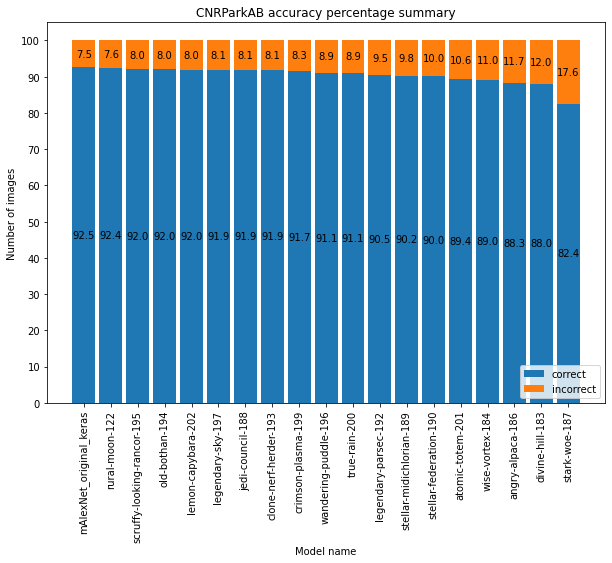

In [126]:
CNRParkAB_num_correct = [11117, 11250, 11561, 11538, 11079, 11565, 11389, 11568, 11573, 11643, 11575, 11629, 11580, 10367, 11331, 11345, 11462, 11469, 11206]
create_accuracy_percentage_plot(CNRParkAB_num_correct, CNRParkAB_PATH, 'CNRParkAB')

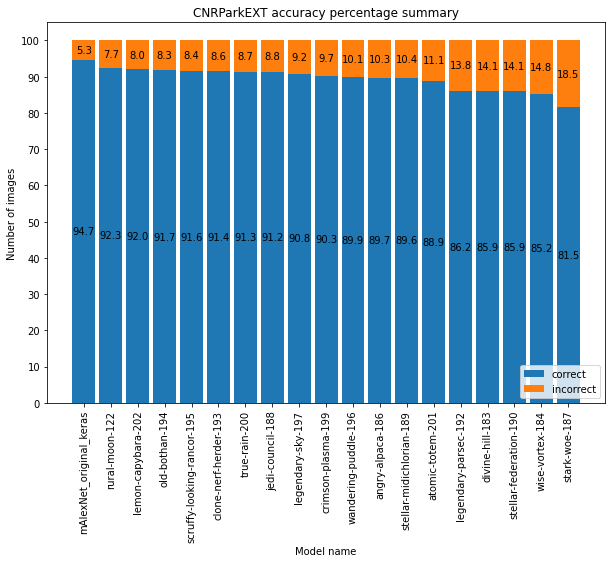

In [132]:
CNRParkEXT_num_correct = [129989, 128806, 132420, 130730, 124498, 132093, 124795, 131582, 133310, 137164, 132823, 133765, 132748, 118111, 124496, 129780, 132248, 130264, 123367]
create_accuracy_percentage_plot(CNRParkEXT_num_correct, CNRParkEXT_PATH, 'CNRParkEXT')

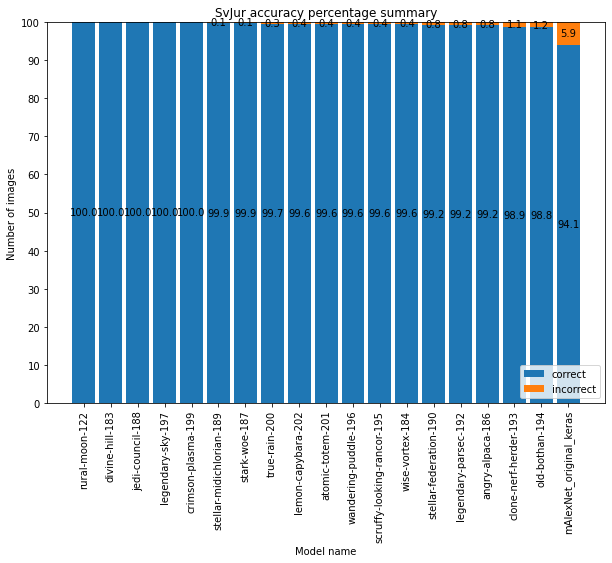

In [131]:
SvJur_num_correct = [33375, 33518, 33273, 33653, 33655, 33655, 33376, 33655, 33535, 31666, 33237, 33656, 33514, 33607, 33377, 33625, 33542, 33517, 33513]
create_accuracy_percentage_plot(SvJur_num_correct, SvJur_PATH, 'SvJur')

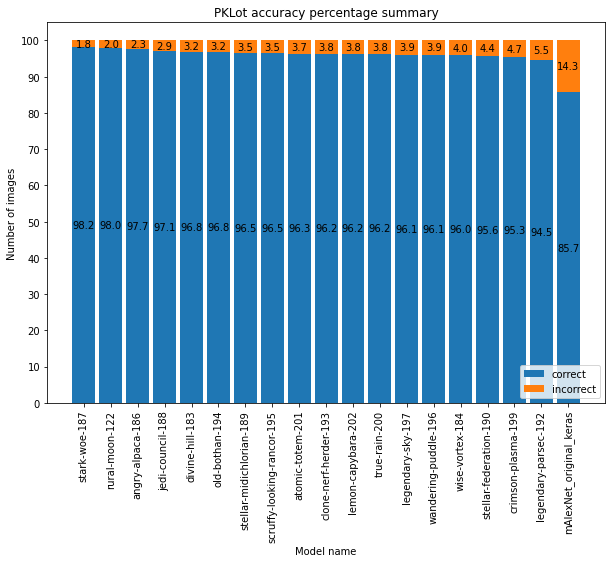

In [122]:
PKLot_num_correct = [680037, 669979, 669241, 663384, 673686, 675862, 657358, 668748, 669216, 596004, 673519, 682051, 671672, 683532, 664940, 671743, 669154, 668651, 668252]
create_accuracy_percentage_plot(PKLot_num_correct, PKLot_PATH, 'PKLot')

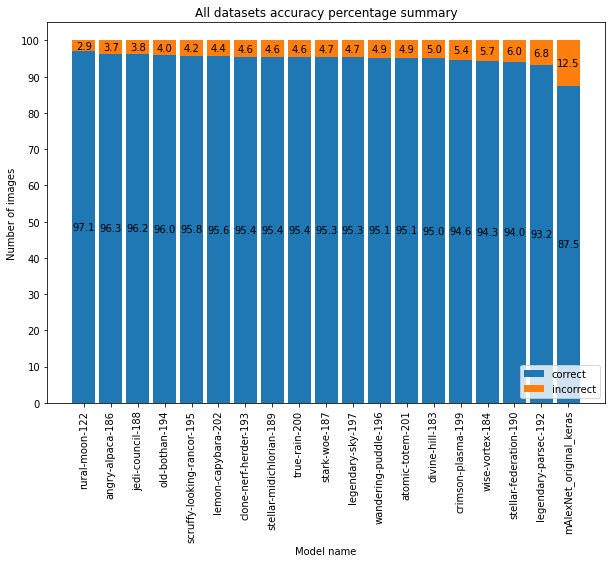

In [130]:
sum_num_correct = [a + b + c + d for a, b, c, d in zip(CNRParkAB_num_correct, CNRParkEXT_num_correct, SvJur_num_correct, PKLot_num_correct)]
create_accuracy_percentage_plot(sum_num_correct, [CNRParkAB_PATH, CNRParkEXT_PATH, SvJur_PATH, PKLot_PATH], 'All datasets')

In [12]:
def test_accuracy_on_dataset_confusion_matrix(model, dataset_path:str, batch_size:int=1000) -> dict:
    file_path = dataset_path if '.txt' in dataset_path else os.path.join(OCD_DATA_DIR, 'splits', dataset_path, 'all.txt')
    pred_labels, true_labels = [], []
    images, labels = [], []

    with open(file_path) as f:
        for line in tqdm(f, total=math.floor(count_file_lines(file_path) / batch_size)):

            while len(images) < batch_size:
                if line == '':
                    # predict the final incomplete batch
                    predictions = model.predict_on_batch(np.array(images))
                    if model.output_shape == (None, 2):
                        pred_labels += [str(np.argmax(pred)) for pred in predictions]
                    else:
                        pred_labels += [str(round(pred[0])) for pred in predictions]
                    true_labels += labels

                    # close file and return dict
                    f.close()

                    # create confusion matrix and display it
                    cm = confusion_matrix(true_labels, pred_labels)
                    labels_one_hot = np.array([0, 1])
                    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_one_hot)
                    disp.plot(cmap=plt.cm.Blues)
                    plt.show()

                    return pred_labels, true_labels
                
                # preprocess image
                orig_filename, label = line.strip().split(' ')
                filename = os.path.join(OCD_DATA_DIR, orig_filename) if '.txt' in dataset_path else os.path.join(OCD_DATA_DIR, dataset_path, orig_filename)
                image = preprocess_image(filename, expand_dims=False)
                
                images.append(image)
                labels.append(label)
                if len(images) < batch_size:
                    line = f.readline()

            # store number of correct / incorrect predictions
            predictions = model.predict_on_batch(np.array(images))
            if model.output_shape == (None, 2):
                pred_labels += [str(np.argmax(pred)) for pred in predictions]
            else:
                pred_labels += [str(round(pred[0])) for pred in predictions]
            true_labels += labels
            images, labels = [], []

  0%|          | 0/12 [00:00<?, ?it/s]

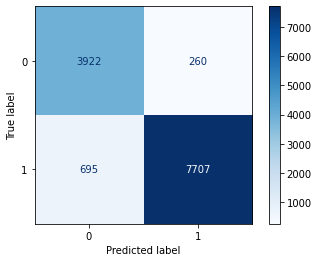

  0%|          | 0/144 [00:00<?, ?it/s]

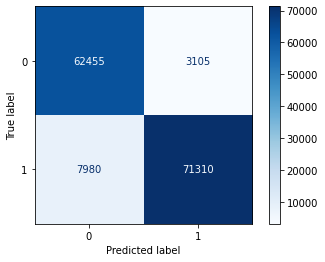

  0%|          | 0/33 [00:00<?, ?it/s]

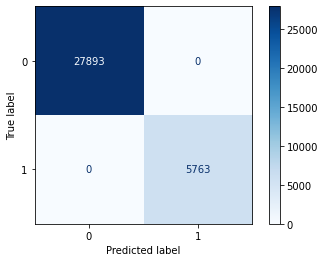

  0%|          | 0/695 [00:00<?, ?it/s]

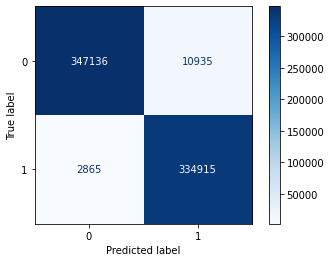

  0%|          | 0/12 [00:00<?, ?it/s]

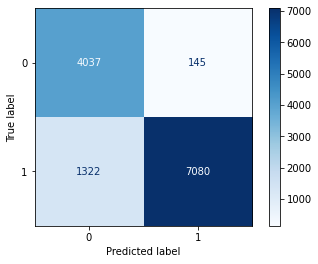

  0%|          | 0/144 [00:00<?, ?it/s]

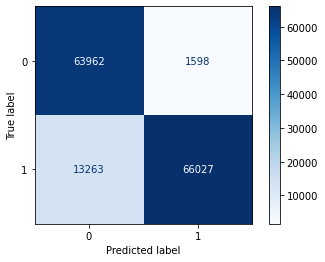

  0%|          | 0/33 [00:00<?, ?it/s]

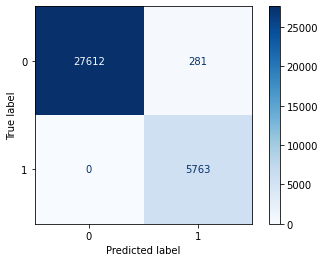

  0%|          | 0/695 [00:00<?, ?it/s]

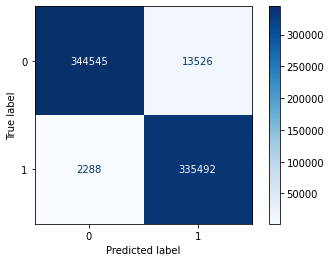

  0%|          | 0/12 [00:00<?, ?it/s]

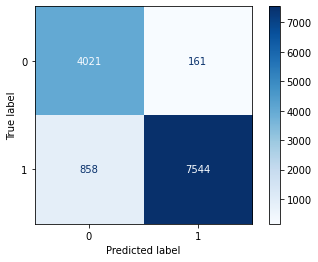

  0%|          | 0/144 [00:00<?, ?it/s]

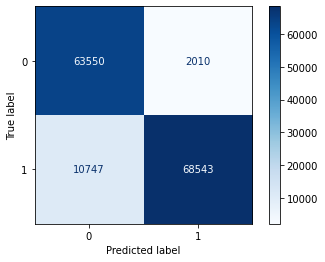

  0%|          | 0/33 [00:00<?, ?it/s]

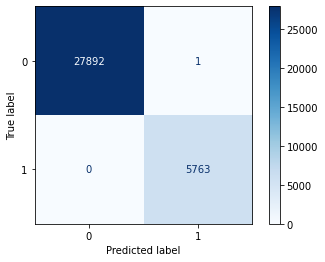

  0%|          | 0/695 [00:00<?, ?it/s]

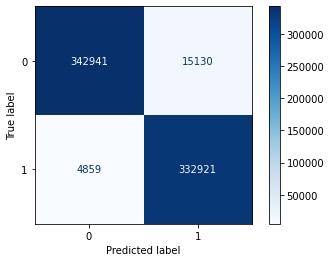

  0%|          | 0/12 [00:00<?, ?it/s]

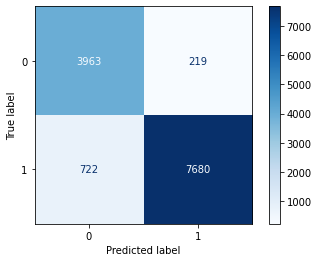

  0%|          | 0/144 [00:00<?, ?it/s]

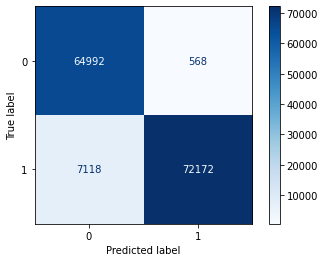

  0%|          | 0/33 [00:00<?, ?it/s]

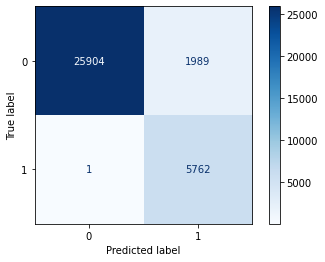

  0%|          | 0/695 [00:00<?, ?it/s]

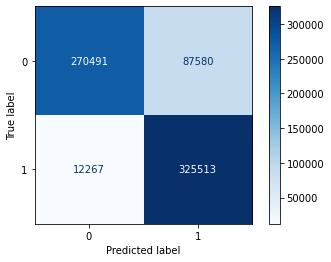

(['1',
  '0',
  '1',
  '0',
  '1',
  '1',
  '0',
  '1',
  '1',
  '0',
  '1',
  '1',
  '0',
  '0',
  '1',
  '1',
  '0',
  '1',
  '0',
  '1',
  '1',
  '0',
  '0',
  '1',
  '1',
  '1',
  '0',
  '1',
  '0',
  '1',
  '1',
  '0',
  '0',
  '0',
  '1',
  '0',
  '1',
  '1',
  '1',
  '0',
  '1',
  '1',
  '0',
  '1',
  '1',
  '1',
  '1',
  '1',
  '0',
  '1',
  '1',
  '1',
  '1',
  '0',
  '1',
  '1',
  '1',
  '1',
  '1',
  '1',
  '0',
  '0',
  '1',
  '1',
  '0',
  '1',
  '0',
  '0',
  '0',
  '1',
  '1',
  '1',
  '1',
  '1',
  '0',
  '1',
  '1',
  '1',
  '0',
  '1',
  '1',
  '0',
  '1',
  '1',
  '1',
  '1',
  '0',
  '0',
  '1',
  '1',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '1',
  '0',
  '1',
  '0',
  '1',
  '0',
  '1',
  '1',
  '1',
  '0',
  '1',
  '0',
  '1',
  '1',
  '1',
  '1',
  '1',
  '0',
  '0',
  '1',
  '1',
  '0',
  '0',
  '1',
  '1',
  '0',
  '1',
  '0',
  '1',
  '0',
  '1',
  '1',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '1',
  '1',
  '1',
  '1',
  '0',
  '0',

In [13]:
model = keras.models.load_model('C:\\Users\\krock\\Desktop\\FIIT\\Ing\\DP\\DP\\models\\rural-moon-122.h5')
test_accuracy_on_dataset_confusion_matrix(model, CNRParkAB_PATH)
test_accuracy_on_dataset_confusion_matrix(model, CNRParkEXT_PATH)
test_accuracy_on_dataset_confusion_matrix(model, SvJur_PATH)
test_accuracy_on_dataset_confusion_matrix(model, PKLot_PATH)

model = keras.models.load_model('C:\\Users\\krock\\Desktop\\FIIT\\Ing\\DP\\DP\\models\\angry-alpaca-186.h5')
test_accuracy_on_dataset_confusion_matrix(model, CNRParkAB_PATH)
test_accuracy_on_dataset_confusion_matrix(model, CNRParkEXT_PATH)
test_accuracy_on_dataset_confusion_matrix(model, SvJur_PATH)
test_accuracy_on_dataset_confusion_matrix(model, PKLot_PATH)

model = keras.models.load_model('C:\\Users\\krock\\Desktop\\FIIT\\Ing\\DP\\DP\\models\\jedi-council-188.h5')
test_accuracy_on_dataset_confusion_matrix(model, CNRParkAB_PATH)
test_accuracy_on_dataset_confusion_matrix(model, CNRParkEXT_PATH)
test_accuracy_on_dataset_confusion_matrix(model, SvJur_PATH)
test_accuracy_on_dataset_confusion_matrix(model, PKLot_PATH)

model = keras.models.load_model('C:\\Users\\krock\\Desktop\\FIIT\\Ing\\DP\\DP\\models\\mAlexNet_original_keras.h5')
test_accuracy_on_dataset_confusion_matrix(model, CNRParkAB_PATH)
test_accuracy_on_dataset_confusion_matrix(model, CNRParkEXT_PATH)
test_accuracy_on_dataset_confusion_matrix(model, SvJur_PATH)
test_accuracy_on_dataset_confusion_matrix(model, PKLot_PATH)